In [105]:
# Utility imports
import os
from pathlib import Path
from typing import Optional
#For visualization and data wrangling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
# For t tests
from scipy import stats
# For regression-based testing
import statsmodels.api as sm
from statsmodels.regression.linear_model import RegressionModel

In [106]:
# Get CWD
FILE_DIR = os.path.abspath('')
FILE_DIR = Path(FILE_DIR)

# Data Imports
There are three files described below:

### Endpoint_Data.csv
Each row represents a replicate of a single growth curve with the indicated condtions for all endpoint analyses.

| column name | description |
| ----- | ----- |
| cumulative_cell_count | raw counts adjusted for the effect of splitting cells every 2 days |
| rep_num | replicate number for figure |
| cell_line | the cell line/condition used (i.e. BCBL1 or BCBL1+vFLIP expression |
| treatment | the guide RNA treatment |
| figure | the figure number as indicated in the manuscript |

### Timecourse_Data.csv
Each row represents a replicate, day and condition for Fig. 2C (ZSGreen and vFLIP expression + cFLIP knockout)

| column name | description |
| ----- | ----- |
| cumulative_cell_count | raw counts adjusted for the effect of splitting cells every 2 days |
| rep_num | replicate number for figure |
| cell_line | the cell line/condition used (i.e. BCBL1 or BCBL1+vFLIP expression |
| treatment | the guide RNA treatment |
| day | days post-transduction with the indicated treatment/guide RNA |

### Test_Table.csv
Each row represents a particular one- (depletion) or two- (rescue) sample t-test to perform on the Endpoint_Data.csv values

| column name | description |
| ----- | ----- |
| test_name | a semantically, unique name for each test |
| figure | replicate number for figure, used for subseting data in Endpoint_Data.csv |
| s1_line | as above, but specifically for the control cell line condition; only used for two-sample tests for rescue |
| s1_treatment | as above, but specifically for the control cell line condition; only used for two-sample tests for rescue (i.e. AAVS1-HygR or ZSGreen cells) |
| s2_line | as above, but specifically for the experimentally interesting cell line condition (i.e. TRAIL-R1 knockout or vFLIP expression) |
| s2_treatment | as above, but specifically for the experimentally interesting cell line condition (i.e. TRAIL-R1 knockout or vFLIP expression |
| test_type| one-sample (depletion) or two-sample (rescue) test |

In [107]:
# Endpoint data import and processing
raw_endpont_data = pd.read_csv(FILE_DIR/"Endpoint_Data.csv", sep=',')

endpoint_data = {}
endpoint_names = raw_endpont_data['figure'].unique()

for fig_num in endpoint_names:
    endpoint_data[fig_num] = raw_endpont_data[raw_endpont_data['figure'] == fig_num].copy()
    
raw_endpont_data.head()

,cumulative_cell_count,rep_num,cell_line,treatment,figure
0,568682.763200,6,BCBL1,AAVS1,1B
1,3562.079511,6,BCBL1,PSMD1,1B
2,371.398964,6,BCBL1,IRF4 M1,1B
3,1937.136205,6,BCBL1,CFLAR D1,1B
4,4762.085308,6,BCBL1,CFLAR D2,1B


In [108]:
# Timecourse data import and processing
raw_timecourse_data = pd.read_csv(FILE_DIR/"Timecourse_Data.csv", sep=',')
raw_timecourse_data['log2_counts'] = np.log2(raw_timecourse_data['cumulative_cell_count'])
raw_timecourse_data['curve'] = raw_timecourse_data['cell_line'].str.cat(raw_timecourse_data['treatment'], sep='+')
raw_timecourse_data.head(150)

,cumulative_cell_count,rep_num,cell_line,treatment,day,log2_counts,curve
0,2.000000e+05,1,ZSGreen,AAVS1,0,17.609640,ZSGreen+AAVS1
1,2.000000e+05,1,ZSGreen,PSMD1,0,17.609640,ZSGreen+PSMD1
2,2.000000e+05,1,ZSGreen,CFLAR D1,0,17.609640,ZSGreen+CFLAR D1
3,2.000000e+05,2,ZSGreen,AAVS1,0,17.609640,ZSGreen+AAVS1
4,2.000000e+05,2,ZSGreen,PSMD1,0,17.609640,ZSGreen+PSMD1
...,...,...,...,...,...,...,...
145,6.127717e+05,5,VFLIP,PSMD1,4,19.224990,VFLIP+PSMD1
146,9.333513e+05,5,VFLIP,CFLAR D1,4,19.832061,VFLIP+CFLAR D1
147,4.373327e+06,5,VFLIP,AAVS1,6,22.060300,VFLIP+AAVS1
148,8.548875e+05,5,VFLIP,PSMD1,6,19.705375,VFLIP+PSMD1


In [109]:
# Table of t tests to perform for endpoints
test_table = pd.read_csv(FILE_DIR/'Test_Table.csv', sep=',')
test_table.head(10)

,test_name,figure,s1_line,s1_treatment,s2_line,s2_treatment,test_type,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,1B_BCBL1_IRF4,1B,NaN,NaN,BCBL1,IRF4 M1,one-sample,NaN,NaN,NaN,NaN,NaN,NaN
1,1B_BCBL1_PSMD1,1B,NaN,NaN,BCBL1,PSMD1,one-sample,NaN,NaN,NaN,NaN,NaN,NaN
2,1B_BCBL1_CFLIP_D1,1B,NaN,NaN,BCBL1,CFLAR D1,one-sample,NaN,NaN,NaN,NaN,NaN,NaN
3,1B_BCBL1_CFLIP_D2,1B,NaN,NaN,BCBL1,CFLAR D2,one-sample,NaN,NaN,NaN,NaN,NaN,NaN
4,1B_BC1_IRF4,1B,NaN,NaN,BC1,IRF4 M1,one-sample,NaN,NaN,NaN,NaN,NaN,NaN
5,1B_BC1_PSMD1,1B,NaN,NaN,BC1,PSMD1,one-sample,NaN,NaN,NaN,NaN,NaN,NaN
6,1B_BC1_CFLIP_D1,1B,NaN,NaN,BC1,CFLAR D1,one-sample,NaN,NaN,NaN,NaN,NaN,NaN
7,1B_BC1_CFLIP_D2,1B,NaN,NaN,BC1,CFLAR D2,one-sample,NaN,NaN,NaN,NaN,NaN,NaN
8,1B_BC2_IRF4,1B,NaN,NaN,BC2,IRF4 M1,one-sample,NaN,NaN,NaN,NaN,NaN,NaN
9,1B_BC2_PSMD1,1B,NaN,NaN,BC2,PSMD1,one-sample,NaN,NaN,NaN,NaN,NaN,NaN


# Utilitiy functions
I've defined two functions for utility purposes in the cells below.

### calculate_relative_aavs1
Used for processing raw counts into relative counts

### run_ttest
Wrapper function for running t tests based on rows in Test_Table.csv

In [110]:
def calculate_relative_aavs1(df: pd.DataFrame) -> None:
    """Calculates cumulative cell counts relative to AAVS1.
    Acts on an existing dataframe inplace.

    Parameters
    ----------
    df : pd.DataFrame
        A dataframe containing cumulative cell count data.
    """
    if 'rel_aavs1' not in df.columns:
        df['rel_aavs1'] = np.nan
    
    control_inds = df['treatment'] == 'AAVS1'
    reps = df['rep_num'].unique()

    for rep in reps:
        rep_inds = df['rep_num'] == rep
        cell_lines = df.loc[rep_inds, 'cell_line'].unique()

        for line in cell_lines:
            cell_line_inds = df['cell_line'] == line

            if 'day' in df.columns:
                inds = rep_inds & cell_line_inds
                days = df.loc[inds, 'day'].unique()
                for day in days:
                    day_inds = df['day'] == day
                    inds = rep_inds & cell_line_inds
                    inds = inds & day_inds
                    subset = df[inds]
                    control = subset[subset['treatment'] == 'AAVS1']['cumulative_cell_count'].values[0]
                    df.loc[inds, 'rel_aavs1'] = df.loc[inds, 'cumulative_cell_count']/control
                    
            else:
                inds = rep_inds & cell_line_inds
            subset = df[inds]
            control = subset[subset['treatment'] == 'AAVS1']['cumulative_cell_count'].values[0]
            df.loc[inds, 'rel_aavs1'] = df.loc[inds, 'cumulative_cell_count']/control

In [111]:
def run_ttest(
    test_name: str,
    s1_line: Optional[str],
    s1_treatment: Optional[str],
    s2_line: str,
    s2_treatment: str,
    test_type: str,
    data: pd.DataFrame,
    **kwargs
    ) -> dict:
    """
    Runs a t test based on Test_Table.csv using data imported from 
    Endpoint_Data.csv
    
    Parameters
    ----------
    test_name : str
         a semantically, unique name for each test
    s1_line : Optional[str]
        control cell line condition; only used for two-sample tests for resc
    s1_treatment : Optional[str]
        guide for the control cell line condition; only used for two-sample
        tests for rescue (i.e. AAVS1-HygR or ZSGreen cells)
    s2_line : str
        experimentally interesting cell line condition (i.e. TRAIL-R1 knockout
        or vFLIP expression)
    s2_treatment : str
        guide for the experimentally interesting cell line condition (i.e.
        TRAIL-R1 knockout or vFLIP expression
    test_type : str
        one-sample (depletion) or two-sample (rescue) test
    data : pd.DataFrame
        dataframe containing values to test

    Returns
    -------
    dict
        A dictionary to later be used for instantiating a dataframe with all
        test results with the following keys:
        'test_name'
        'ctrl_line'
        'ctrl_guide'
        'experimental_line'
        'experimental_guide'
        'test_type'
    """

    results = {
        'test_name': test_name,
        'ctrl_line': s1_line,
        'ctrl_guide': s1_treatment,
        'experimental_line': s2_line,
        'experimental_guide': s2_treatment,
        'test_type': test_type
        }

    samp2 = data[(data['cell_line'] == s2_line) * (data['treatment'] == s2_treatment)]
    samp2 = samp2['rel_aavs1']
    
    if test_type == 'one-sample':
        _, pval = stats.ttest_1samp(samp2, 1, alternative='less')

    else:
        samp1 = data[(data['cell_line'] == s1_line) * (data['treatment'] == s1_treatment)]
        samp1 = samp1['rel_aavs1']
    
        _, pval = stats.ttest_ind(
            samp1,
            samp2,
            alternative = 'less'
            )
        
    results['pvalue'] = pval
    return results

## Normalization and visualization
I'm now going to go through each figure and calculate relative cell counts (compared to AAVS1) for each cell line included with that figure and plot them to confirm the appearance of the data

<Figure size 1440x540 with 0 Axes>

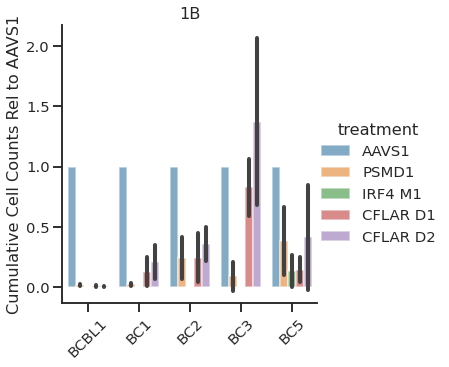

<Figure size 1440x540 with 0 Axes>

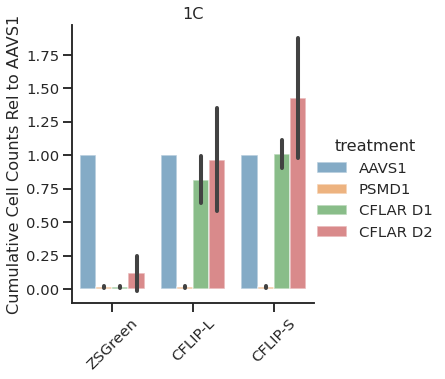

<Figure size 1440x540 with 0 Axes>

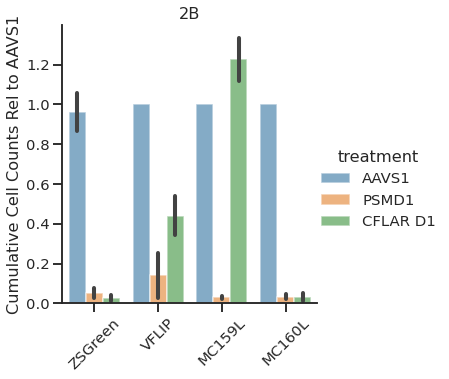

<Figure size 1440x540 with 0 Axes>

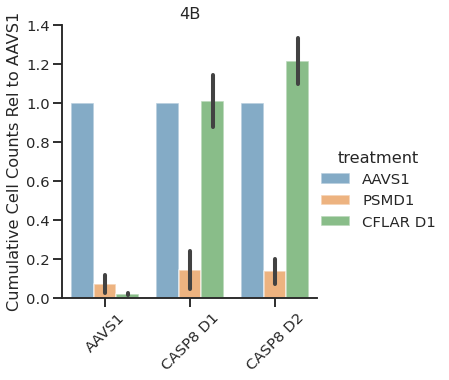

<Figure size 1440x540 with 0 Axes>

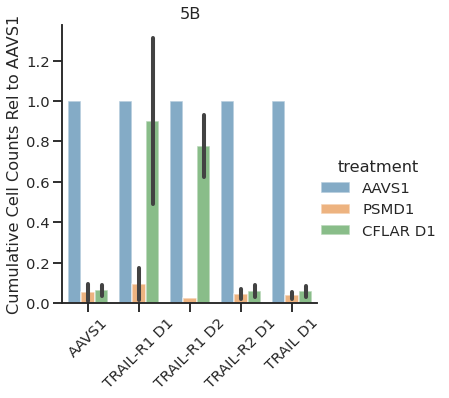

<Figure size 1440x540 with 0 Axes>

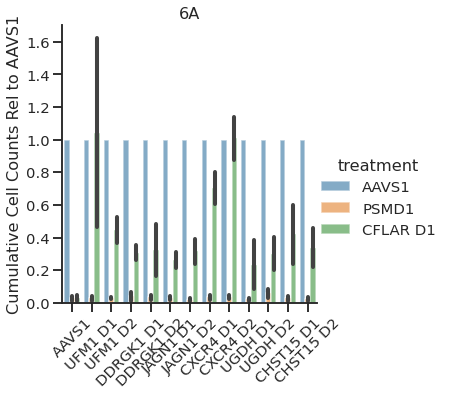

In [112]:
for fig_num,df in endpoint_data.items():

    calculate_relative_aavs1(df)

    sns.set_context("talk", font_scale=.9)
    plt.figure(figsize=(20,7.5))
    ax =sns.catplot(
        data=df,
        kind="bar",
        x="cell_line",
        y="rel_aavs1",
        hue="treatment",
        ci="sd",
        alpha=.6
        )
    for axes in ax.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
    plt.xlabel("")
    plt.ylabel("Cumulative Cell Counts Rel to AAVS1")
    plt.title(fig_num)

    df.to_csv(FILE_DIR/f'{fig_num}_rel.csv')

## Run endpoint analysis t tests...

Data will be saved in CWD/{figure}.csv

In [113]:
tests = test_table.to_dict(orient='records')
endpoint_results = {}
for fn in endpoint_names:
    endpoint_results[fn] = []

for test in tests:
    figure = test['figure']
    endpoint_results[figure].append(run_ttest(data=endpoint_data[figure], **test))

for figure,results in endpoint_results.items():
    test_results_df = pd.DataFrame(results)
    test_results_df.set_index('test_name', inplace=True)
    test_results_df['significant'] = test_results_df['pvalue'] <= .05
    print(test_results_df)
    test_results_df.to_csv(FILE_DIR/f'{figure}.csv', sep=',', index=True)

                   ctrl_line  ctrl_guide experimental_line experimental_guide  \
test_name                                                                       
1B_BCBL1_IRF4            NaN         NaN             BCBL1            IRF4 M1   
1B_BCBL1_PSMD1           NaN         NaN             BCBL1              PSMD1   
1B_BCBL1_CFLIP_D1        NaN         NaN             BCBL1           CFLAR D1   
1B_BCBL1_CFLIP_D2        NaN         NaN             BCBL1           CFLAR D2   
1B_BC1_IRF4              NaN         NaN               BC1            IRF4 M1   
1B_BC1_PSMD1             NaN         NaN               BC1              PSMD1   
1B_BC1_CFLIP_D1          NaN         NaN               BC1           CFLAR D1   
1B_BC1_CFLIP_D2          NaN         NaN               BC1           CFLAR D2   
1B_BC2_IRF4              NaN         NaN               BC2            IRF4 M1   
1B_BC2_PSMD1             NaN         NaN               BC2              PSMD1   
1B_BC2_CFLIP_D1          NaN

## Normalization and visualization
I'm now going to calculate relative cell counts (compared to AAVS1) for each cell line/day/replicate

I'll also plot the data in two ways (standard line graph and scatter w/ regression lines)

In [114]:
calculate_relative_aavs1(raw_timecourse_data)

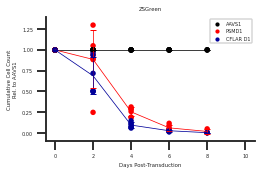

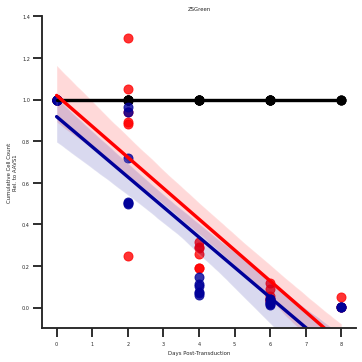

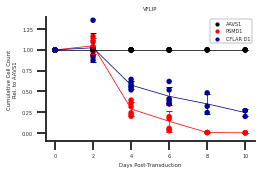

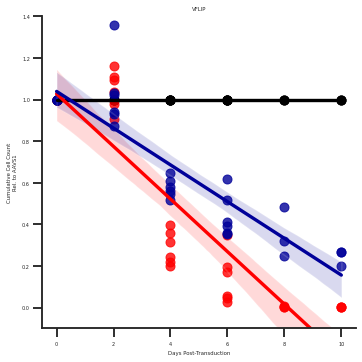

In [115]:
funcs = [sns.lineplot, sns.lmplot]
for line in ['ZSGreen', 'VFLIP']:
    sns.set_style("ticks")
    sns.set_context("talk", font_scale=.3)
    plt.figure(figsize=(12*.3, 8*.3))
    kwargs = [
        {
            'linewidth': 0.75,
            'ci': 'sd',
            'err_style': 'bars',
            'err_kws': {'capsize':3, 'elinewidth':0.75}
            },
        {
            'ci': 95
        }
    ]
    for func, kwargs in zip(funcs, kwargs):
        df = raw_timecourse_data[raw_timecourse_data['cell_line'] == line]
        my_palette= ['black','#FF0000','#000099']
        ax = func(
            data = df,
            x = "day",
            y = "rel_aavs1",
            hue = "treatment",
            palette = my_palette,
            legend = False,
            **kwargs
            )

        if func == sns.lineplot:
            ax = sns.scatterplot(
                data = df,
                x = "day",
                y = "rel_aavs1",
                hue = "treatment",
                palette = my_palette,
                s = 30,
                linewidth = 0
                )
            ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(.25))
            ax.set(xlim=(-.5, 10.5))
            plt.legend(markerscale=.3)
        
        ax.set(ylim=(-.1, 1.4))
        sns.despine()
        plt.title(line)
        plt.ylabel("Cumulative Cell Count\nRel. to AAVS1")
        plt.xlabel("Days Post-Transduction")
        plt.tight_layout()
        plt.savefig(FILE_DIR/f'{line}_{func.__name__}_Rescue_Timecourse.pdf')

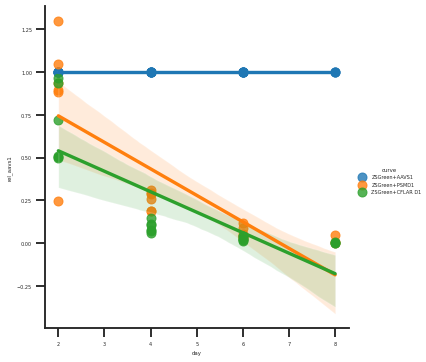

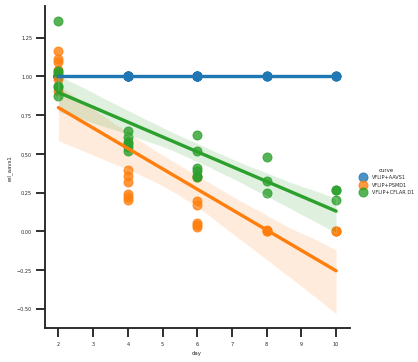

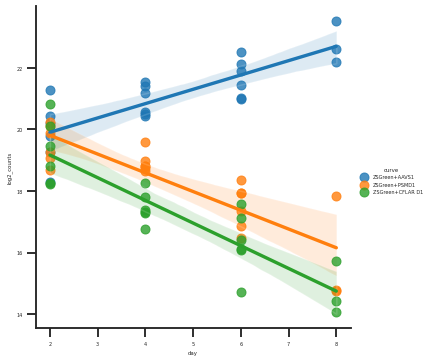

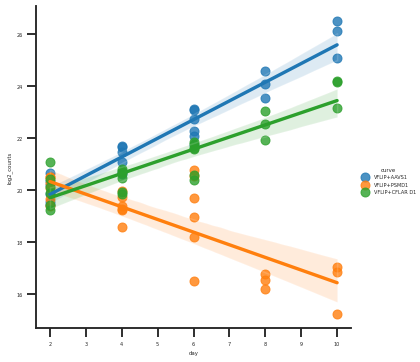

In [116]:
for y in ['rel_aavs1','log2_counts']:
    df = raw_timecourse_data[raw_timecourse_data['day'] > 0]
    sns.lmplot(x='day', y=y, data=df[df['cell_line']=='ZSGreen'], hue='curve')
    sns.lmplot(x='day', y=y, data=df[df['cell_line']=='VFLIP'], hue='curve')

# Regression-based hypothesis testing
The idea here is to perform regression using one or two variables to predict the relative cell counts

For depletion, I'm testing if the coefficient of days given *rel_counts ~ day* is significantly negative

For rescue, I'm testing if the coefficient of vFLIP/ZSgreen expression status given *rel_counts ~ day + vflip_expression* is significantly positive (vFLIP over ZSGreen)

I defined a helper function for making a dataframe containing untruncated p values for each test.

In [117]:
def make_ols_res_df(model: RegressionModel) -> pd.DataFrame:
    """_summary_

    Parameters
    ----------
    model : RegressionModel
        The statsmodels regression object.

    Returns
    -------
    pd.DataFrame
        Dataframe containing untruncated terms for coef (variable name),
        std_err, and pval for each weight/bias.
    """
    cols = [model.params, model.bse, model.pvalues/2]
    df = pd.concat(cols, axis=1)
    col_mapper = {k:v for k,v in zip(df.columns, ['coef', 'std_err', 'pval'])}
    df.rename(columns=col_mapper, inplace=True)
    return df

In [118]:
for line in ['ZSGreen', 'VFLIP']:
    for treatment in ['PSMD1', 'CFLAR D1']:
        df = raw_timecourse_data[raw_timecourse_data['cell_line'] == line].copy()
        df = df[df['treatment'] == treatment]
        df = df[df['day'] > 0]
        _treatment = treatment.replace(' ','')
        ols = sm.OLS.from_formula(f"rel_aavs1 ~ day", data=df)
        model = ols.fit()
        df = make_ols_res_df(model)
        print(model.summary())
        df.to_csv(FILE_DIR/f'2C_{line}_{_treatment}_depletion.csv')


for treatment in ['PSMD1', 'CFLAR D1']:
        df = raw_timecourse_data[raw_timecourse_data['treatment'] == treatment].copy()
        df = df[(df['day'] > 0) & (df['day'] < 10)]
        df['vflip_overexpression'] = df['cell_line'] == 'VFLIP'
        ols = sm.OLS.from_formula("rel_aavs1 ~ day + vflip_overexpression", data=df)
        model = ols.fit()
        df = make_ols_res_df(model)
        print(model.summary())
        df.to_csv(FILE_DIR/f'2C_{line}_{treatment}_rescue.csv')

                            OLS Regression Results                            
Dep. Variable:              rel_aavs1   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     37.30
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           7.15e-06
Time:                        09:58:15   Log-Likelihood:                 1.2645
No. Observations:                  21   AIC:                             1.471
Df Residuals:                      19   BIC:                             3.560
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0543      0.127      8.288      0.0

In [119]:
stats.ttest_1samp([0.32189324256886, 0.246071637665173, 0.482826928080302], 1, alternative="less")


Ttest_1sampResult(statistic=-9.308278787395802, pvalue=0.005672715958112016)